In [313]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time

import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, ReLU, GlobalAveragePooling1D, AveragePooling1D, ZeroPadding1D
from tensorflow.keras.layers import Flatten, GaussianNoise, Layer, RepeatVector, Permute, Lambda, Multiply, Dot
from tensorflow.keras.layers import Dropout, Input, concatenate, Add, LeakyReLU, GlobalMaxPool1D, SeparableConv1D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, BatchNormalization, LayerNormalization, Activation, ConvLSTM2D, Flatten, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import multilabel_confusion_matrix

# Detektor

Cieľom projektu bude vytvoriť provizórny detektor na základe konvolučnej neurónovej siete, ktorého úlohou bude detekovať jeden z nasledujúcich stavov: sitting, laying, standing, walking, manipulation. Pre transparentnosť uvádzam, že mobilnú Android aplikáciu, ktorá slúži na zber dát, ako i samotnú detekciu, mám z firmy Twinzo, a že podobný projekt využívajúci neurónovú sieť na detekciu jedného z vyššie spomenutých stavov (a ďalších stavov, s ktorými som však ja nepracoval) už existuje, avšak, samotný zber dát pre tento projekt bol iba v mojej réžii, rovnako ako aj vytvorenie môjho vlastného modelu neurónovej siete. Od Twinza som si "požičial" ideu detektoru, rovnako aj Android aplikáciu určenú na zber dát. 

# Kde by sa mohol detektor využívať? 
Nosnou myšlienkou detektoru od Twinza bolo predovšetkým detekovanie stavu falling (ktorý ja pre nedostatok nazbieraných dát vynechávam). Tento detektor sa následne využíva na detekciu pádu (človeka) v napr. industriálnych odvetviach, ktorých súčasťou sú rôzne sklady, montažné haly, či fabriky. V týchto fabrikách sa môžu nachádzať aj priestory, v ktorých môže byť zvyšené riziko straty vedomia, napr. v dôsledku vysokých teplôt alebo úniku plynu v prípade poruchy. 

Detektor by mal chrániť ľudí pohybujúcich sa v takýchto rizikových priestoroch (a nie len v týchto priestoroch) tým, že ak príde k strate vedomia a pracovník sa zrúti k zemi, detektor detekuje pád (stav falling) a následnú nečinnosť (stav laying), okamžite zaalarmuje dispečing v danej firme, ktorý môže k pracovníkovi v bezvedomí poslať včasnú pomoc. Je predpoklad, že zvukový signál si môže dispečer všimnúť skôr ako zbadá nehybné telo na kamerovom zázname. V takýchto situáciach môže ísť o sekundy a toto je jednoduchá a lacná pomoc, ktorá by mohla v takejto situácii zachrániť život. 

Dodávam, že predpokladom je, aby mal pracovník mobil s operačným systémom Android a zapnutým detektorom vo vrecku. V tomto projekte pracujeme s týmto predpokladom, a preto aj všetky dáta boli zbierané týmto spôsobom, že sme mali mobil vo vrecku s výnimkou jediného stavu, a to je manipulation. 

Ako som už spomínal, v mojom projekte stav falling nefiguruje, čo sa však ľahko môže zmeniť do budúcnosti po získaní potrebných dát. 

Bez stavu falling sa využitie môjho detektoru bude líšiť. Detektor s takýmito stavmi by sa dal využiť na monitorovanie dĺžky sedenia, chôdze, či státia počas dňa. Podobné funkcie existujú dnes v rôznych smart hodinkách, ktoré vás notifikáciou upozornia v prípade, ak dlho sedíte a nabadajú vás k tomu, aby ste sa postavili a poprechádzali. 


# Dáta

Dáta som zbieral pomocou aplikácie, ktorej .apk verzia na operačný systém Android je k dispozícii na stiahnutie na mojom GitHub-e. Na zber dát budeme využívať vstavaný pohybový senzor (akcelerometer) v mobile. Akcelerometer v mobile slúži na detekciu pohybu, náklonu mobilu, či celkovú orientáciu zariadenia, ktorá je uvádzaná hodnotami na osách X,Y,Z. Pre jednoduchú predstavu, akcelerometer sa napr. využíva pri zistení toho, či mobil je otočený na šírku alebo na výšku, aby napríklad mobil prispôsobil obraz na displeji. 

Jeden záznam merania bude obsahovať 8 features - time, activity, X, Y, Z, lX, lY, lZ 

time - čas, v ktorom bol daný záznam nameraný

activity - aktivita, ktorá bola pri danom meraní vykonávaná. Možné hodnoty activity sú stavy: sitting, laying, walking, standing, manipulation 

X, Y, Z - zrýchlenie zariadenia merané v m/s vrátané pôsobenia gravitačnej sily 

lX, lY. lZ - zrýchlenie zariadenia merané v m/s bez pôsobenia gravitačnej sily

Dáta som zbieral na jedno zariadenie a to konkrétne na Samsung Galaxy J5. Je dosť možné, že citlivosť akcelerometrov sa môže líšiť model od modelu a výrobcu od výrobcu, preto som sa rozhodol nezbierať dáta aj na iné zariadenia. 

V následujúcom linku je bližší popis senzorov v Android zariadeniach. Nás budú zaujímať iba 2 senzory, a to TYPE_ACCELEROMETER (X,Y,Z) a TYPE_LINEAR_ACCELERATION (lX, lY, lZ).  

https://developer.android.com/guide/topics/sensors/sensors_overview.html?hl=zh-en

Dáta majú nasledovnú podobu: 

In [322]:
data = pd.read_csv('data/measurements.csv')
data

,time,Activity,X,Y,Z,lX,lY,lZ
0,2021-12-29T20:29:02.010+0100,Standing,3.275268,-9.120711,-1.552640,0.273066,0.043722,0.126496
1,2021-12-29T20:29:02.096+0100,Standing,2.991555,-8.789114,-1.978808,-0.008518,0.300256,-0.239737
2,2021-12-29T20:29:02.098+0100,Standing,3.216610,-8.868123,-1.903390,0.173230,0.176997,-0.131456
3,2021-12-29T20:29:02.099+0100,Standing,3.193865,-9.074024,-1.590947,0.120388,-0.023123,0.144790
4,2021-12-29T20:29:02.100+0100,Standing,2.747346,-9.425972,-1.778892,-0.260905,-0.300056,-0.034524
...,...,...,...,...,...,...,...,...
185217,2021-12-31T16:29:56.221+0100,Manipulation,2.871845,-9.121908,-0.456095,-0.214973,0.030753,0.420674
185218,2021-12-31T16:29:56.241+0100,Manipulation,2.954445,-9.050082,-0.227449,-0.105898,0.082064,0.519456
185219,2021-12-31T16:29:56.260+0100,Manipulation,3.187880,-8.981848,-0.118513,0.102029,0.120238,0.502714
185220,2021-12-31T16:29:56.280+0100,Manipulation,3.496732,-8.913613,-0.154426,0.328705,0.150779,0.373441


# Zber dát
Popis procesu zberu dát" 


V aplikácii zvolíme "Collector"


<img src="images/screen1.jpg" width="200" height="200"/>


Následne si vyberieme aktivitu, ktorú ideme vykonávať.


<img src="images/screen2.jpg" width="200" height="200"/>


A nastavíme čas, kedy sa aktivita začne merať a akú dlhú dobu sa bude merať. 


<img src="images/screen3.jpg" width="200" height="200"/>



Rozhodol som sa merať každú aktivitu po dobu 5 sekúnd. Jedno meranie aktivity obsahuje približne 250 záznamov, keďže každých 20 milisekúnd sa vykoná meranie jedného záznamu. 

Ako som už spomínal, mobil sa pri každej aktivite s výnimkou manipulation nachádzal vo vrecku. 

Pri meraní aktivít som si uvedomoval podstatnú vec, a to, že potrebujem, čo najkomplexnejšie dáta. Teda, aby som zachytil, čo najviac pozícii, v ktorých sa môže mobil vo vrecku vyskytovať. Popíšme si ako vyzerali merania pre jednotlivé aktivity.

Walking

Klasická chôdza, mobil som umiestnil do pravého, aj ľavého vrecka (do zadného som mobil nedával), vo vrecku (záleži aj od veľkosti vrecka) môže byť mobil umiestnený v štyroch polohách - displejom otočený ku mne na stojato, displejom otočený ku mne naopak, dispejom otočený von na stojato, displejom otočený von naopak. Vykonával som rôzne štýly chôdze: pomalá, rýchla, poklus, pochodovanie, ležerná chôdza. 

Sitting 

Sedenie, opäť som obmieňal 4 možné polohy mobilu vo vreckách, sedenie bolo aj nečinné, ale aj s jemnými pohybmi trupu, či rúk, sedenie s vystretými, či zalomenými nohami. 

Laying 

Ležanie, opäť som obmieňal 4 možné polohy mobilu vo vreckách, skúšanie rôznych polôh, ležanie na bruchu, na chrbte, na boku. 

Standing

Státie, nehybné státie, ale aj s pohybmi trupu, či rúk, s pokrčenou nohou.  

Manipulation 

Pri manipulácii som sa snažil simulovať rôzne bežné pohyby s mobilom v ruke, napr. mobil je položený na stole a zdvihnem ho, mobil mám vo vrecku, pozriem sa koľko je hodín, robenie si selfie, mobil mám v rukách a odkladám ho do vrecka, či pokladám na stôl. 

Pri spracovaní dát som sa rozhodol, že z nameraných záznamov pre jednotlivé aktivity (pre jednu aktivitu to bolo asi 250 záznamov) budem používať 128 záznamov pre každú aktivitu, pričom prvých 10 záznamov každej aktivity odignorujem. To znamená, že jedno meranie aktivity malo v trainX (testX) tvar matice (128,  6) a pre túto maticu sa v trainY (testY) nachádzal label prislúchajúcej aktivity (v tvare one-hot encoding). 

In [314]:
# beriem 128 zaznamov, prvych 10 zaznamov merania vsak ignorujem 
last_data_relevance = 128
points_to_ignore = 10

gravit_multiplier = 100
linear_multiplier = 10

In [315]:
class State:
    def __init__(self, name, id):
        self.name = name
        self.id = id

states = [State("Sitting", 0), State("Laying", 0), State("Standing", 1), 
          State("Walking", 2), State("Manipulation", 3)]

In [316]:
# nacitanie datasetu, vratime trainX, trainY, testX, testY
def load_dataset():
    total_records = np.array([])
    trainX, trainY, testX, testY = np.empty((0, last_data_relevance, 6)), np.empty((0, 1)), np.empty((0, last_data_relevance, 6)), np.empty((0, 1))
        
    for state_index, state in enumerate(states):
        print("Processing state: " + state.name)
        
        data = pd.read_csv('data/measurements.csv')
        data = data.loc[data['Activity'] == state.name]
        data = data[['time', 'X', 'Y', 'Z', 'lX', 'lY', 'lZ']]
        
        data["time"] = pd.to_datetime(data['time'])
        
        
        last_row = None
        acc = np.array([])
        records = np.array([])
        labels = np.array([])
        point_count = 0
        ignored_points = 0
        accounted_points = 0
        
                
        for index, row in data.iterrows():
            if ignored_points > points_to_ignore:
                if last_row is not None and (row["time"] - last_row["time"]).seconds > 2:                    
                    if np.array([acc]).shape[1] == (last_data_relevance * 6): 
                        records = np.append(records, np.array([acc]))
                        labels = np.append(labels, state.id)
                    
                    acc = np.array([])
                    ignored_points = 0
                    accounted_points = 0
                    last_row = row
                    continue
                
                if accounted_points < last_data_relevance:
                    acc = np.append(acc, row["X"] / gravit_multiplier)
                    acc = np.append(acc, row["Y"] / gravit_multiplier)
                    acc = np.append(acc, row["Z"] / gravit_multiplier) 
                    acc = np.append(acc, row["lX"] / linear_multiplier)
                    acc = np.append(acc, row["lY"] / linear_multiplier)
                    acc = np.append(acc, row["lZ"] / linear_multiplier)
                    accounted_points += 1
                last_row = row
            else:
                ignored_points += 1
        
        
        records = np.asarray(records).reshape(-1, last_data_relevance, 6)
        
        data_split = int(len(records) / 10 * 8)
        trainX = np.vstack((trainX, records[:data_split, :]))
        testX = np.vstack((testX, records[data_split:, :]))
        
        labels = np.asarray(labels).reshape(-1, 1)
        trainY = np.vstack((trainY, labels[:data_split, :]))
        testY = np.vstack((testY, labels[data_split:, :]))
    
    trainX, trainY = shuffle(trainX, trainY, random_state=0)
    testX, testY = shuffle(testX, testY, random_state=0)
    
    trainX_reshaped = trainX.reshape((-1, 2), order='F')
    testX_reshaped = testX.reshape((-1, 2), order='F')
    
    trainY = to_categorical(trainY)
    
    testY = to_categorical(testY)
    
    return trainX, trainY, testX, testY

In [317]:
trainX, trainY, testX, testY = load_dataset()

Processing state: Sitting
Processing state: Laying
Processing state: Standing
Processing state: Walking
Processing state: Manipulation


Pri zostavení architektúry pre moju konvolučnú neurónovú sieť som sa rozhodol veľmi neexperimentovať a zvolil som podobný prístup ako na cvičeniach. Zvyčajne pri vytváraní architektúry pre konvolučnú neurónovú sieť začnem konvolučnými vrstvami, ktoré nasledujú pooling vrstvy a následne hľadám najvhodnejšiu architektúru podľa výkonu na validačných dátach. Spočiatku som sa trápil s overfittingom, ktorý som dokázal zredukovať pridaním dropout vrstiev. Loss funkciu som zvolil categorical crossentropy, čo je typická loss funkcia pre klasifikáciu s viacerými triedami, ako optimizer som vsadil na istotu a bežne používaneho Adam-a. Nový prvok v mojej architektúre je causal padding, ktorý sa zdá byť vhodný pre time series dáta, čo sú aj moje dáta.

In [319]:
cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=5, padding='causal', activation='relu', input_shape=(128,6))) 
cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn.add(MaxPooling1D(pool_size=2)) 
cnn.add(Dropout(0.5))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.5))
cnn.add(MaxPooling1D(pool_size=2))  
cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(4, activation='softmax'))

cnn.compile(loss='categorical_crossentropy', optimizer=Adam(0.001),  metrics=['accuracy'])

history = cnn.fit(trainX, trainY, epochs=20, batch_size=16, 
                    verbose=1, validation_split=0.3)

Epoch 1/20
26/26 [==============================] - 6s 204ms/step - loss: 1.1978 - accuracy: 0.3390 - val_loss: 1.1696 - val_accuracy: 0.4489
Epoch 2/20
26/26 [==============================] - 5s 188ms/step - loss: 1.0134 - accuracy: 0.5951 - val_loss: 1.0455 - val_accuracy: 0.7159
Epoch 3/20
26/26 [==============================] - 5s 193ms/step - loss: 0.7618 - accuracy: 0.7927 - val_loss: 0.8403 - val_accuracy: 0.8807
Epoch 4/20
26/26 [==============================] - 5s 188ms/step - loss: 0.4860 - accuracy: 0.8780 - val_loss: 0.6082 - val_accuracy: 0.9432
Epoch 5/20
26/26 [==============================] - 5s 195ms/step - loss: 0.2885 - accuracy: 0.9220 - val_loss: 0.4722 - val_accuracy: 0.9489
Epoch 6/20
26/26 [==============================] - 5s 189ms/step - loss: 0.2091 - accuracy: 0.9512 - val_loss: 0.4069 - val_accuracy: 0.9432
Epoch 7/20
26/26 [==============================] - 5s 190ms/step - loss: 0.1670 - accuracy: 0.9610 - val_loss: 0.3435 - val_accuracy: 0.9432
Epoch 

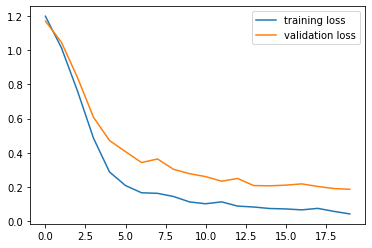

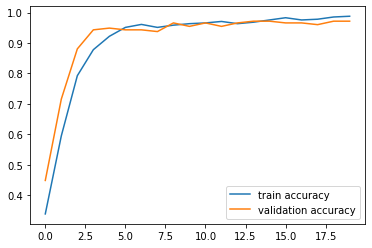

In [320]:
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

In [321]:
test_score = cnn.evaluate(testX, testY)
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

5/5 [==============================] - 0s 7ms/step - loss: 0.1821 - accuracy: 0.9800


test loss: 0.18210279941558838 | test acc: 0.9800000190734863
